### Install and Import Dependencies

In [92]:
# !pip install tensorflow-gpu
# !pip install opencv-python mediapipe 
!pip install -U scikit-learn scipy matplotlib
# !pip install sklearn
! pip install pydot
! pip install graphviz


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 47.0/47.0 kB 593.5 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import sklearn
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
import datetime as dt

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print(tf.test.is_built_with_cuda())

True


In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
!nvidia-smi

Sat Nov 19 14:23:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.86       Driver Version: 526.86       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8     6W /  N/A |    319MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Keypoints using MediaPipe Hosistic

## Set up the MediaPipe model

In [31]:
mp_holistic = mp.solutions.holistic # MP Holistic model
mp_drawing = mp.solutions.drawing_utils # MP drawing utilities

In [5]:
def mediapipe_detection(image, model):
    '''
    This function
    Args:
         image: the image that it takes in (frame)
         model: the mp holistic model
    Returns:
         image: the processed image
         results:
    '''
    # open cv grabs image in BGR. But mp requires RGB img
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color Conversion
    image.flags.writeable = False                   # Img is no longer writable
    results = model.process(image)                  # Make prediction on the image (frames)
    image.flags.writeable = True                    # Img is now writable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color Conversion
    return image, results
    

In [4]:
def draw_landmarks(image, results): 
    # Will grab the results & render it on the image
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [8]:
def draw_styled_landmarks(image, results):
    # Will grab the results & render it on the image (custom formatted landmarks this time)
    
    # Draw face connections
    mp_drawing.draw_landmarks(image, # the input image
                              results.face_landmarks, # renders from the result
                              mp_holistic.FACEMESH_TESSELATION, # which method we are doing
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # colors the landmarks
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) # colors the joints
                             )
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), # colors the landmarks
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) # colors the joints
                             )
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), # colors the landmarks
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2) # colors the joints
                             ) 
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), # colors the landmarks
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) # colors the joints
                             )

## Capture Video

In [9]:
# Capturing video
cap = cv2.VideoCapture(0)

# Set Mp model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # First detection, then track the keypoints
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic) # returns last frame, last results
        print(results)
        
        # Draw Landmarks
        draw_styled_landmarks(image, results) # draws the LMarks on the frames
        
        # Show to screen
        cv2.imshow("openCV Feed",image)

        # Break Gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [17]:
results.face_landmarks.landmark

[x: 0.48974257707595825
y: 0.6525076031684875
z: -0.022340048104524612
, x: 0.48948758840560913
y: 0.6078029870986938
z: -0.046738360077142715
, x: 0.48896223306655884
y: 0.620489776134491
z: -0.022706709802150726
, x: 0.4800153076648712
y: 0.5681391358375549
z: -0.03786789998412132
, x: 0.4892205595970154
y: 0.5955216884613037
z: -0.05051671341061592
, x: 0.488457053899765
y: 0.5792574882507324
z: -0.04806302487850189
, x: 0.4863305389881134
y: 0.5397759675979614
z: -0.02719174511730671
, x: 0.42020848393440247
y: 0.5371014475822449
z: 0.004760400392115116
, x: 0.4851611852645874
y: 0.5119178891181946
z: -0.024082079529762268
, x: 0.48484447598457336
y: 0.495789498090744
z: -0.027499407529830933
, x: 0.48237553238868713
y: 0.43276989459991455
z: -0.022593796253204346
, x: 0.48992177844047546
y: 0.6587464213371277
z: -0.0206717811524868
, x: 0.4899303615093231
y: 0.6629384756088257
z: -0.01721654087305069
, x: 0.48981985449790955
y: 0.6642031073570251
z: -0.012857790105044842
, x: 0.49

In [32]:
frame # last frame that we extracted from camera

array([[[187, 187, 181],
        [187, 187, 181],
        [187, 187, 181],
        ...,
        [153, 152, 152],
        [154, 153, 153],
        [153, 153, 153]],

       [[187, 187, 181],
        [187, 187, 181],
        [187, 187, 181],
        ...,
        [153, 152, 152],
        [154, 153, 153],
        [153, 153, 153]],

       [[187, 186, 182],
        [187, 186, 182],
        [187, 186, 182],
        ...,
        [153, 151, 153],
        [154, 153, 154],
        [153, 153, 154]],

       ...,

       [[ 89,  83,  87],
        [ 88,  82,  86],
        [ 86,  80,  84],
        ...,
        [161, 164, 156],
        [161, 166, 159],
        [158, 164, 157]],

       [[ 87,  82,  84],
        [ 86,  81,  83],
        [ 86,  80,  82],
        ...,
        [166, 169, 160],
        [163, 168, 160],
        [161, 167, 159]],

       [[ 86,  81,  82],
        [ 85,  80,  81],
        [ 85,  79,  80],
        ...,
        [160, 162, 152],
        [156, 162, 152],
        [162, 169, 159]]

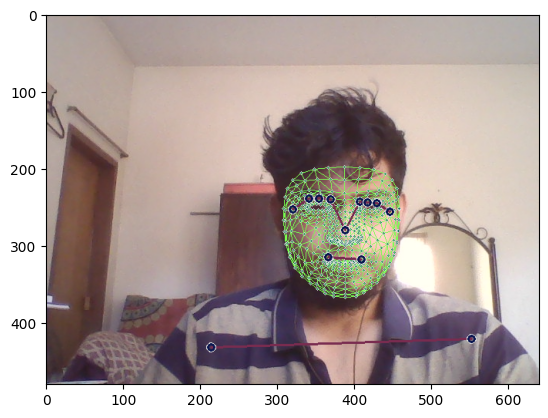

In [15]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Extract keypoint values
Concatenate the result values into a numpy array. If no values at a time, create numpy zeroes array with same shape

In [16]:
len(results.pose_landmarks.landmark)

33

In [52]:
# # Grabbing the pose lMark values in a numpy array
# pose = []
# for res in results.pose_landmarks.landmark: # Grabbing the values of the 1st lMark of pose_landmarks
#     test = np.array([res.x, res.y, res.z, res.visibility])
#     pose.append(test)

In [17]:
len(results.face_landmarks.landmark)*3

1404

In [58]:
# # same thing as above, in a single line
# # pose lMarks
# pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)

In [60]:
# pose.shape # flattened lMarks

(132,)

If we don't have a landmark from a certain area, we are going to create an  empty array of numpy zeroes

In [18]:
np.zeros(21*3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [71]:
# # Left Hand LMarks
# # If you get results from the Lmarks, then extract those results, else create a blank array of 0's of (21*3)
# lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

In [73]:
# # Right Hand Lmarks
# # If you get results from the Lmarks, then extract those results, else create a blank array of 0's of (21*3)
# rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [74]:
# rh

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Extracting KeyPoints for all the Holistic LMarks

In [10]:
# If you get results from the Lmarks, then extract those results, else create a blank array of 0's
# pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
# lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
# rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)


In [17]:
def extract_keypoints(results):
    '''
    Function to extract keypoints from the frames
    Arguments:
        results: takes in the results of the LMarks
    Returns:
        concat_keypoints: concatanation of all the landmarks from all the holistic
    '''
    
    # If you get results from the Lmarks, then extract those results, else create a blank array of 0's
#     pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
#     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
#     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
#     concat_keypoints = np.concatenate([pose, face, lh, rh]) # concatenating all the keypoint values together
    
    return face

In [18]:
extract_keypoints(results).shape # All the extracted keypoints

(1404,)

Face LM      = 468 x 3 </br>
Pose LM      = 33 x 4  </br>
LeftHand LM  = 21 x 3  </br>
RightHand LM = 21 x 3 

In [22]:
result_test = extract_keypoints(results)
result_test

array([ 0.60729158,  0.58468264, -1.34686852, ...,  0.        ,
        0.        ,  0.        ])

In [96]:
# np.save('0',result_test) # saves the result array in np format

In [97]:
# np.load('0.npy') # loads back the result from np array file

array([ 0.63236433,  0.40008286, -1.07911265, ...,  0.        ,
        0.        ,  0.        ])

# Setup Folders for Collection

## Setting up some constants

In [19]:
# Path for the exported data (numpy arrays)
data_path = os.path.join('MP_Data_2') 

# Actions that we try to detect
actions = np.array(['Hello', 'Thanks', 'ILoveYou'])

# No. of videos worth of data
no_sequences = 5

# Videos are going to be 30 frames in length
sequence_length = 10



Each video has 30 frames multiplied by 3 actions multiplied by 1662 keypoints

## Create folders

In [ ]:
# Folders
# Hello  - action
## 0  - video number
### 0 - frame number
### 1
### 2
### ..
### 29  - 30 frames for each video

## 1
## 2
## ..
## 29


# Thanks
## 0
## 1
## 2
## ..
## 29


# I Love You
## 0
## 1
## 2
## ..
## 29

In [33]:
for action in actions: # loops through the actions
    for sequence in range(no_sequences):  # loop through the 30 different videos
        try:
            # Creates folder, sub folders, sub sub folders in os
            os.makedirs(os.path.join(data_path,action,str(sequence)))
        except:
            pass # Pass, if folders already created
            

# Collect KeyPoint values for training and testing

Loop through and collect 30 frames per video, for 30 videos per action, for 3 actions

In [21]:
# Capturing video
cap = cv2.VideoCapture(0)

# Set Mp model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        
        # Loop through sequences, aka videos
        for sequence in range(no_sequences):
            
            # Loop through video length, aka sequence length
            for frame_num in range(sequence_length):
                
                # Extract 30 FRAMES of Keypoints per video
                # Collection breaks- breaks bet. each video.

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic) # returns last frame, last results
                print(results)

                # Draw Landmarks
                draw_styled_landmarks(image, results) # draws the LMarks on the frames

                # Apply collection wait logic (breaks between)
                if frame_num == 0:
                    cv2.putText(image, 'Starting Collection',(120,200),
                               cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} video Number {}'.format(action,sequence),
                               (15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow("openCV Feed",image)
                    
                    cv2.waitKey(2000) # if at frame 0, take a 2s break
                    
                else:
                    cv2.putText(image, 'Collecting frames for {} video Number {}'.format(action,sequence),
                               (15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow("openCV Feed",image)
                    
                # Extract & Export Keypoints
                keypoints = extract_keypoints(results) # All the extracted keypoints (concatenated) of the frame
                npy_path = os.path.join(data_path,action,str(sequence),str(frame_num)) # set up path to store the keypoints in np file format
                np.save(npy_path, keypoints) # save the keypoint in the specific path set
                
                # Break Gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [1]:
cap.release()
cv2.destroyAllWindows() 

NameError: name 'cap' is not defined

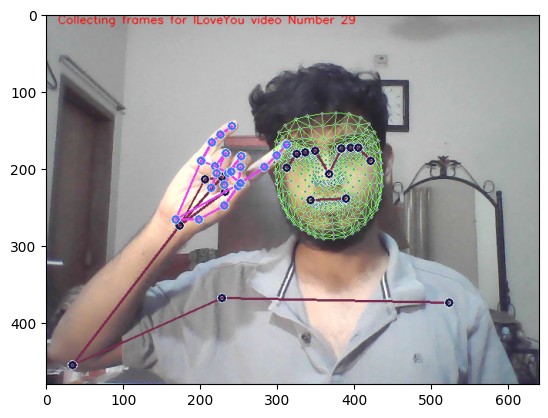

In [156]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Preprocess Data & Create Labels and Features

In [22]:
# To split the data
from sklearn.model_selection import train_test_split

# To convert the data into one-hot encoded vector
from tensorflow.keras.utils import to_categorical

In [23]:
# Dictionary that has the label mapped to a number
label_map = {label:num for num, label in enumerate(actions)}

In [24]:
label_map

{'Hello': 0, 'Thanks': 1, 'ILoveYou': 2}

## Structuring the keypoints from the frames
Create 90 big arrays with 30 frames in each 1 of those arrays, with 1662 values in each frame, which represents our keypoints

In [34]:
sequences= [] # blank array. To represent our feature data (X)
labels = [] # blank array. To represent our labels data (y)

for action in actions: # 3 actions
    for sequence in range(no_sequences): # 30 sequences in each label
        window = []  # blank array. To represent all of the frames in that particular sequence
        for frame_num in range(sequence_length): # Each sequence/video of 30 frames in length
            
            # taking the npy results of the frame number of that particular video(sequence)
            res = np.load(os.path.join(data_path,action,str(sequence), "{}.npy".format(frame_num))) 
            window.append(res) # append the results grabbed, to the window array
        
        # Append the window grabbed to the feature data (X)
        sequences.append(window) # will have 90 videos' feature, each video having 30 frames, and each frame having 1662 keypoints
        
        # Append the label from the label_map
        labels.append(label_map[action])
            

90

In [36]:
# Converting the features to a numpy array
np.array(sequences).shape

# (90 videos, 30 frames each video, 1662 keypoints in each frame)

(15, 10, 1404)

In [37]:
# Converting the labels to a numpy array
np.array(labels).shape

(15,)

In [38]:
# Features 
X = np.array(sequences) 

# Labels (One-hot encoded vector)
y = to_categorical(labels).astype(int)

In [39]:
X.shape

(15, 10, 1404)

In [40]:
import pandas as pd
df1 = pd.DataFrame(data = X)

ValueError: Must pass 2-d input. shape=(15, 10, 1404)

In [165]:
y

# Hello      - 1 0 0
# Thanks     - 0 1 0
# I Love You - 0 0 1

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15)

In [171]:
X_train.shape

(76, 30, 1662)

In [172]:
X_test.shape

(14, 30, 1662)

In [173]:
y_train.shape

(76, 3)

In [174]:
y_test.shape

(14, 3)

# Construct the LSTM Model

In [175]:
from tensorflow.keras.models import Sequential # Sequential Neural Network
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

In [176]:
# Setting up TensorBoard Logs
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [177]:
X.shape[2]

1662

In [178]:
# Setting the input_shape for the Deep NN model
input_shape = (X.shape[1], X.shape[2])

In [179]:
input_shape

(30, 1662)

In [180]:
actions.shape[0]

3

In [181]:
# Building the model
def create_LSTM_model():
    
    model = Sequential() # instantiating the model

    # Layer 1
    # 64 LSTM units, 
    # return_sequences=True to stack the sequences, bcoz the next layer is going to need those,
    # activation Function ='relu'
    # Input_shape = 30 frames per prediction * 1662 keypoint values
    model.add(LSTM(64, return_sequences=True, activation='relu', input_shape = input_shape))

    # Layer 2
    model.add(LSTM(128, return_sequences=True, activation='relu'))

    # Layer 3
    # return_sequences=False, bcoz no LSTM layer under it
    model.add(LSTM(64, return_sequences=False, activation='relu'))

    # Dense Layer 1
    model.add(Dense(64, activation='relu'))

    # Dense Layer 2
    model.add(Dense(32, activation='relu'))

    # Final Output Layer
    # activation='softmax' so that we get a probabilistic output
    model.add(Dense(actions.shape[0], activation='softmax'))

    # Display the models summary.
    model.summary()
    
    # Return the constructed lstm model
    return model

In [182]:
LSTM_model = create_LSTM_model()

# Display success message
print("LSTM Model Created Successfully!")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

In [183]:
plot_model(LSTM_model, to_file="LSTM_model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Compile LSTM Model

In [184]:
LSTM_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = 'accuracy')

## Define Callbacks

In [186]:
# Stop when val_loss has stopped improving. min = doesn't decrease anymore
# restore_best_weights --> Restores the best weight as the final weight
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, mode='min',restore_best_weights=True)

# logging the training metrics to a csv file

from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger('LSTM training.csv')

## Train the model

In [187]:
# epochs = 500
# Validation data = 10% of training data
LSTM_model_training_history = LSTM_model.fit(X_train, y_train, epochs=500,batch_size=8, shuffle=True, validation_split=0.05, callbacks = [early_stopping_callback, csv_logger, tb_callback])

Epoch 1/500
9/9 [==============================] - 4s 205ms/step - loss: 1.1408 - accuracy: 0.4444 - val_loss: 1.0023 - val_accuracy: 0.5000
Epoch 2/500
9/9 [==============================] - 1s 156ms/step - loss: 0.9465 - accuracy: 0.5278 - val_loss: 1.0138 - val_accuracy: 0.7500
Epoch 3/500
9/9 [==============================] - 1s 159ms/step - loss: 1.0387 - accuracy: 0.4028 - val_loss: 1.0749 - val_accuracy: 0.2500
Epoch 4/500
9/9 [==============================] - 1s 150ms/step - loss: 0.7765 - accuracy: 0.7083 - val_loss: 0.6464 - val_accuracy: 0.7500
Epoch 5/500
9/9 [==============================] - 1s 155ms/step - loss: 0.5408 - accuracy: 0.7778 - val_loss: 0.8694 - val_accuracy: 1.0000
Epoch 6/500
9/9 [==============================] - 1s 151ms/step - loss: 0.7076 - accuracy: 0.7778 - val_loss: 2.3996 - val_accuracy: 0.0000e+00
Epoch 7/500
9/9 [==============================] - 1s 152ms/step - loss: 0.9889 - accuracy: 0.7083 - val_loss: 0.4341 - val_accuracy: 0.7500
Epoch 8/5

# Evaluate the trained model

In [188]:
res = LSTM_model.predict(X_test)

1/1 [==============================] - 0s 274ms/step


In [189]:
actions[np.argmax(res[4])]

'Hello'

In [190]:
actions[np.argmax(y_test[4])]

'Hello'

In [191]:
model_eval_history = LSTM_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 96ms/step - loss: 0.5798 - accuracy: 0.7857


# Save weights

In [192]:
# Get the loss and accuracy from model_evaluation_history
model_eval_loss, model_eval_accuracy = model_eval_history

# Define the string date format
date_time_format = '%Y_%m_%d__%H_%M_%S'
# Get the current Date and Time in a DateTime Object
current_date_time_dt = dt.datetime.now()
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for the model
model_file_name = f'LSTM_model__Date_Time_{current_date_time_string}__Loss_{model_eval_loss}__Accuracy_{model_eval_accuracy}.h5'

# Save the model
LSTM_model.save(model_file_name)

# Evaluation using Confusion Matrix & Accuracy

In [193]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [194]:
y_hat = LSTM_model.predict(X_test)

1/1 [==============================] - 0s 50ms/step


In [195]:
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()

In [196]:
multilabel_confusion_matrix(y_true, y_hat)

array([[[10,  0],
        [ 3,  1]],

       [[ 9,  0],
        [ 0,  5]],

       [[ 6,  3],
        [ 0,  5]]], dtype=int64)

In [197]:
accuracy_score(y_true, y_hat)

0.7857142857142857

# Test in Real Time

In [216]:
colors = [(245,117,16), (117,245,16), (16,117,245)]

# Function for visualizing probability
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

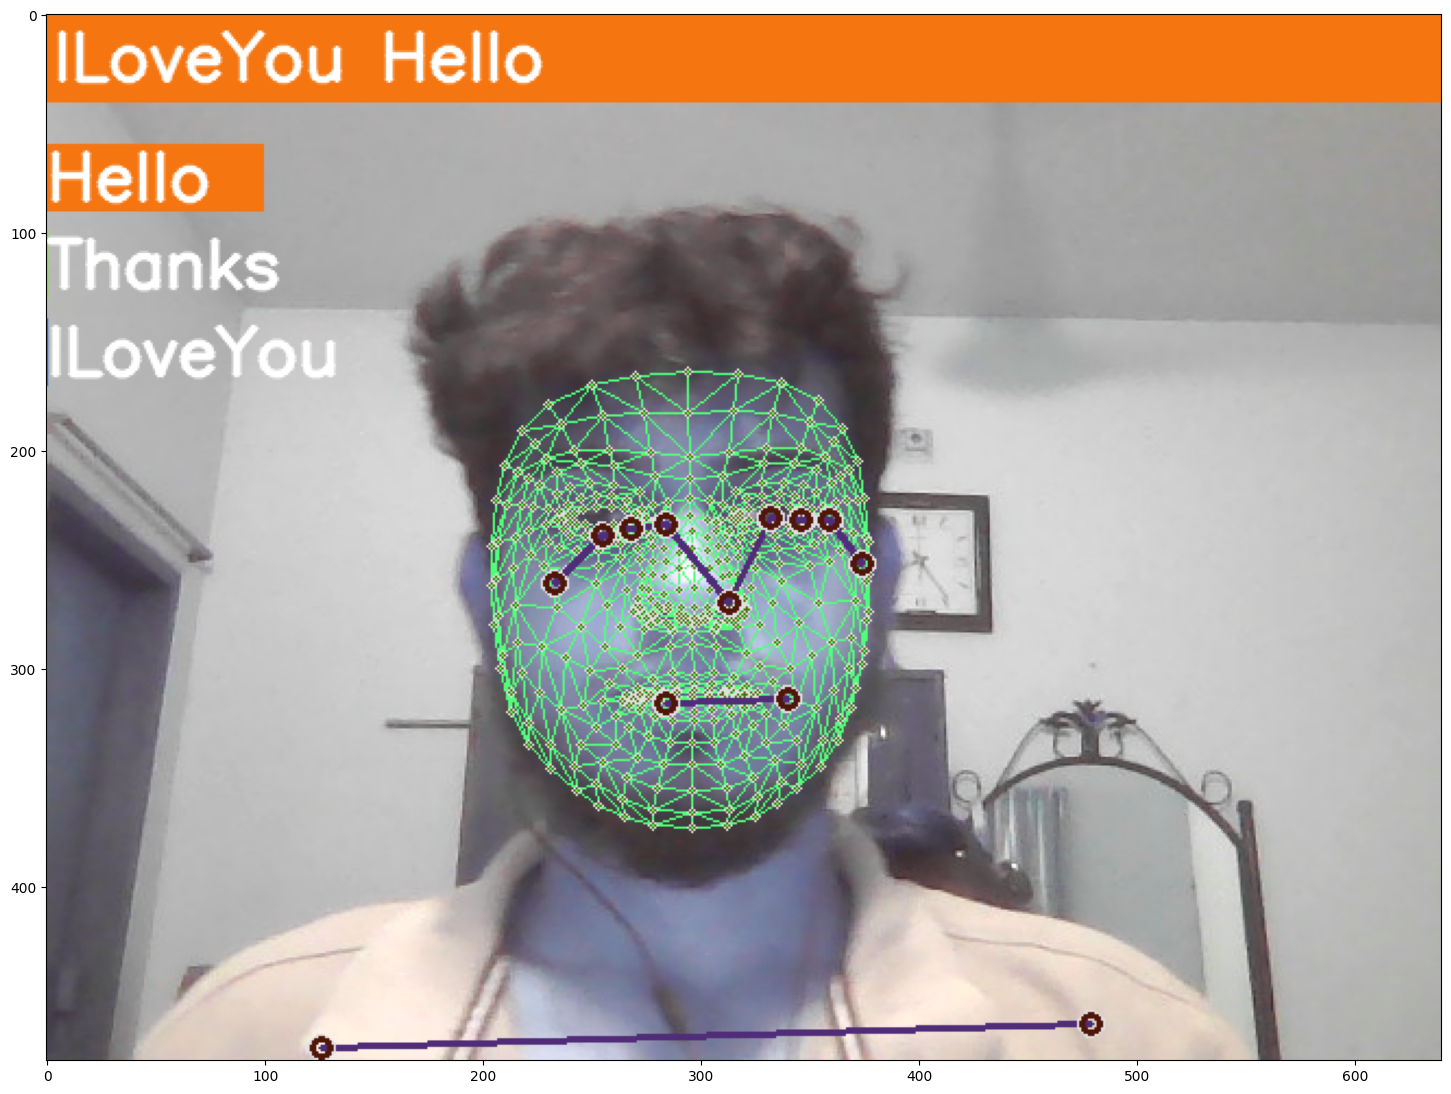

In [223]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions,image, colors))

In [220]:
# 1. New detection variables
sequence = [] # collect 30 frames to generate prediction
sentence = [] # concatenates the history of detections
predictions = []
threshold = 0.7

# We need 30 frames of data (sequence) for prediction


# Capturing video
cap = cv2.VideoCapture(0)

# Set Mp model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # First detection, then track the keypoints
    
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic) # returns last frame, last results
        print(results)
        
        # Draw Landmarks
        draw_styled_landmarks(image, results) # draws the LMarks on the frames
        
        # 2. Prediction Logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:] # Grabs the last 30 sets of keypoints
        
        if len(sequence)==30: # Make predicrtion only when length of frame==30
            res = LSTM_model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res)) # appending all the predictions
            
            # 3. Visualization Logic
            # predictions[-10:] --> last 10 predictions
            # Checking if the last 10 frames had the exact same predictions
            if np.unique(predictions[-10:])[0]==np.argmax(res): 

                if res[np.argmax(res)] > threshold:

                    if len(sentence) > 0: # if the sentence contains some words
                        if actions[np.argmax(res)] != sentence[-1]: # if current_action != last sentence in our string
                            sentence.append(actions[np.argmax(res)]) # if it isn't, then append the current detected action into the sentence array

                    else: # if there is no words in the sentence
                        sentence.append(actions[np.argmax(res)]) 
                
            '''
            logic- 1st, check if we have words in the senctece array. If not, append to it.
                   If we do, check if the current predicted action isn't the same as the last precited sentence. 
                   If it's not, then append. But if it is, then skip the append to prevent duplication
            '''    
                    
            if len(sentence) > 5:  # If sentence > 5 words
                sentence = sentence[-5:]  # Grab the last 5 values

            # Viz Probabilities
            image = prob_viz(res, actions, image, colors)

        # Rendering it to the image
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1) # -1 fills out the rectangle
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                        # concatenating the sentence array together, with a space between
            
#         cv2.rectance(image, (0,0), (640,40), (245, 117, 16), -1) # -1 fills out the rectangle
#         cv2.putText(image, ''.join(sentence), # concatenating the sentence array together, with a space between
#                     (3,30), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow("openCV Feed",image)

        # Break Gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [215]:
cap.release()
cv2.destroyAllWindows()  

In [147]:
X_test[0].shape

(30, 1662)

Shape is incorrect. </br>
Model expects shape to be (1,30,1662). Here 1 denotes the number of sequences

In [146]:
LSTM_model.predict(X_test[0])

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_3/lstm_9/transpose' defined at (most recent call last):
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1899, in _run_once
      handle._run()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_6536\2071606222.py", line 1, in <module>
      LSTM_model.predict(X_test[0])
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\rnn\base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\rnn\lstm.py", line 625, in call
      last_output, outputs, states = backend.rnn(
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 4783, in rnn
      inputs = tf.nest.map_structure(swap_batch_timestep, inputs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 4780, in swap_batch_timestep
      return tf.compat.v1.transpose(input_t, axes)
Node: 'sequential_3/lstm_9/transpose'
transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node sequential_3/lstm_9/transpose}}]] [Op:__inference_predict_function_36280]

In [149]:
np.expand_dims(X_test[0], axis=0).shape

(1, 30, 1662)

In [150]:
LSTM_model.predict(np.expand_dims(X_test[0], axis=0))
# Now we get a successful prediction after doing np.expand_dims

1/1 [==============================] - 0s 42ms/step


array([[0.35028288, 0.3344652 , 0.31525198]], dtype=float32)